Ceci est le code pour le projet de green ai ayant pour but de faire un dashboard intéractif permettant de visualiser le scoring de chaque centrale nucléaire et de chaque région et prédire leur émission de CO2. On prendra en compte dans le même temps les besoin énergétique de chaque région et poseront différentes équations permettant de mieux analyser chaque centrale.

Le dataset sera issus d'une source vérifié qui est data.gouv et du site de edf : <br>
https://opendata.edf.fr/explore/?sort=modified&disjunctive.theme&disjunctive.publisher&disjunctive.keyword.

Cette solution à pour but de promouvoir la transition énergétique des différentes régions et de pouvoir poser un état des lieux de la situation national et international.
Notre solution sera basé sur un volet d'analyse avec jupyter notebook et enfin d'une web app permettant de visualiser et comprendre les différents résultat d'analyse.


In [2]:
import pandas as pd
#import folium
#import geopandas as gpd
#import geoviews as gv

In [3]:
datacentrale = pd.read_excel("Centrale data.gouv//Excel centrales.xlsx")
CO2pays = pd.read_csv("Centrale data.gouv//emissions-de-co2-consolidees-par-pays-du-groupe-edf.csv",encoding="utf-8",sep=";")
datacentrale.columns = [col.lower() for col in datacentrale.columns]
datacentrale[['latitude', 'longitude']] = datacentrale['point_gps_wsg_84'].str.split(',', expand=True)
datacentrale['latitude'] = datacentrale['latitude'].astype(float)
datacentrale['longitude'] = datacentrale['longitude'].astype(float)

Affichage Dataframe


0. Columns


In [3]:
print("Colonnes de datacentrale :", datacentrale.columns, "\n")
print("Colonnes de CO2pays :", CO2pays.columns, "\n")
# print("Colonnes de hydraulique :", hydraulique.columns)
# print("Colonnes de nucléaire :", nucléaire.columns)
# print("Colonnes de thermique :", thermique.columns)

print("Nombre de centrales :", len(datacentrale))
print("Nombre de pays :", len(CO2pays))



Colonnes de datacentrale : Index(['tri', 'perimetre_juridique', 'perimetre_spatial', 'spatial_perimeter',
       'filiere', 'sector', 'centrale', 'categorie_centrale',
       'power_station_category', 'annee_de_mise_en_service',
       'puissance_installee', 'unite', 'departement', 'code_postal', 'commune',
       'coordonnees_x_wgs', 'coordonnees_y_wgs', 'point_gps_wsg_84', 'region',
       'latitude', 'longitude'],
      dtype='object') 

Colonnes de CO2pays : Index(['Tri', 'Year', 'Périmètre juridique', 'Legal perimeter',
       'Périmètre spatial', 'Spatial perimeter', 'CO2 emissions', 'Unit',
       'Méthode de consolidation', 'Consolidation method', 'Geo Shape',
       'Geo Point'],
      dtype='object') 

Nombre de centrales : 183
Nombre de pays : 60


1. Datacentrale


In [4]:
print("Shape of datacentrale: ", datacentrale.shape)
datacentrale.head()

Shape of datacentrale:  (183, 21)


,tri,perimetre_juridique,perimetre_spatial,spatial_perimeter,filiere,sector,centrale,categorie_centrale,power_station_category,annee_de_mise_en_service,...,unite,departement,code_postal,commune,coordonnees_x_wgs,coordonnees_y_wgs,point_gps_wsg_84,region,latitude,longitude
0,1,EDF SA,"France mÃ©tropolitaine, sans la Corse ni les i...","Metropolitan France, excluding Corsica and the...",Hydraulique,Hydraulic,AIGLE (L'),Lac,Lake,1945,...,MW,CANTAL,15200.0,CHALVIGNAC,45.243249,2.224798,"45.243248798,2.22479826896",NaN,45.243249,2.224798
1,2,EDF SA,"France mÃ©tropolitaine, sans la Corse ni les i...","Metropolitan France, excluding Corsica and the...",Hydraulique,Hydraulic,ASTON,EclusÃ©e,Lock,1947,...,MW,ARIEGE,9310.0,ASTON,42.776674,1.677132,"42.7766740737,1.67713212735",NaN,42.776674,1.677132
2,3,EDF SA,"France mÃ©tropolitaine, sans la Corse ni les i...","Metropolitan France, excluding Corsica and the...",Hydraulique,Hydraulic,BATHIE (LA),Lac,Lake,1960,...,MW,SAVOIE,73540.0,BATHIE,45.645274,6.444928,"45.6452741068,6.44492758326",NaN,45.645274,6.444928
3,4,EDF SA,"France mÃ©tropolitaine, sans la Corse ni les i...","Metropolitan France, excluding Corsica and the...",Hydraulique,Hydraulic,BORT,Lac,Lake,1952,...,MW,CORREZE,19110.0,BORT-LES-ORGUES,45.412904,2.498423,"45.4129035471,2.49842267793",NaN,45.412904,2.498423
4,5,EDF SA,"France mÃ©tropolitaine, sans la Corse ni les i...","Metropolitan France, excluding Corsica and the...",Hydraulique,Hydraulic,BROMMAT,Lac,Lake,1933,...,MW,AVEYRON,12600.0,BROMMAT,44.767566,2.683544,"44.7675662205,2.68354402065",NaN,44.767566,2.683544


**show missing values**


In [5]:
print("Missing values in datacentrale: ", datacentrale.isnull().sum())


Missing values in datacentrale:  tri                           0
perimetre_juridique           0
perimetre_spatial             0
spatial_perimeter             0
filiere                       0
sector                        0
centrale                     81
categorie_centrale           56
power_station_category       75
annee_de_mise_en_service     62
puissance_installee           0
unite                         0
departement                  62
code_postal                 137
commune                      62
coordonnees_x_wgs           137
coordonnees_y_wgs           137
point_gps_wsg_84             62
region                      164
latitude                     62
longitude                    62
dtype: int64


2. CO2pays


In [6]:
print("Shape of CO2pays: ", CO2pays.shape)
CO2pays.head()

Shape of CO2pays:  (60, 12)


,Tri,Year,Périmètre juridique,Legal perimeter,Périmètre spatial,Spatial perimeter,CO2 emissions,Unit,Méthode de consolidation,Consolidation method,Geo Shape,Geo Point
0,1,2022,Groupe EDF,EDF group,Monde,World,23077.903054,ktonnes,Intégration Globale,Full integration,NaN,NaN
1,2,2022,Groupe EDF,EDF group,Allemagne,Germany,1.238200,ktonnes,Nette,Net,"{""coordinates"": [[[[6.798106316000087, 53.6044...","51.1042052, 10.382490881"
2,3,2022,Groupe EDF,EDF group,Belgique,Belgium,701.758907,ktonnes,Nette,Net,"{""coordinates"": [[[2.521799927545686, 51.08754...","50.638605688, 4.638880233"
3,4,2022,Groupe EDF,EDF group,Brésil,Brazil,584.220987,ktonnes,Nette,Net,"{""coordinates"": [[[[-38.944203253999945, -13.3...","-10.780141976, -53.091847002"
4,5,2022,Groupe EDF,EDF group,République populaire de Chine,People's Republic of China,6526.450000,ktonnes,Nette,Net,"{""coordinates"": [[[[111.01050866000003, 19.683...","36.557620326, 103.833601188"


Calcul des différents taux d'émissions de CO2


In [7]:
emission_factors = {
    'Hydraulic': 4,
    'Nuclear': 12,
    'Coal': 820,
    'Gas': 490,
    'Oil': 650,
    'Renewable': 10  # Placeholder for all renewables
}

# Assume a utilization factor for each plant type to estimate annual production
utilization_factors = {
    'Hydraulic': 0.5,
    'Nuclear': 0.9,
    'Coal': 0.7,
    'Gas': 0.6,
    'Oil': 0.6,
    'Renewable': 0.3
}

# Function to estimate annual production in kWh
def estimate_annual_production(capacity_mw, sector):
    # Convert capacity to kWh and multiply by utilization factor and hours per year
    return capacity_mw * 1e6 * utilization_factors.get(sector, 0.5) * 24 * 365

# Function to calculate CO2 emissions based on sector and installed capacity
def calculate_co2_emissions(sector, capacity_mw):
    annual_production_kwh = estimate_annual_production(capacity_mw, sector)
    # Calculate emissions in metric tons (1 metric ton = 1e6 grams)
    return annual_production_kwh * emission_factors.get(sector, 10) / 1e6

# Calculate CO2 emissions for each row in the dataframe
datacentrale['co2_emissions_ton'] = datacentrale.apply(lambda x: calculate_co2_emissions(x['sector'], x['puissance_installee']), axis=1)

datacentrale[["centrale","co2_emissions_ton"]].sort_values(by="co2_emissions_ton",ascending=False).head(10)

,centrale,co2_emissions_ton
78,NaN,175896420.0
54,NaN,167097000.0
126,CHOOZ B,141912000.0
127,CHOOZ B,141912000.0
128,CIVAUX,141438960.0
129,CIVAUX,141438960.0
70,NaN,133152000.0
93,NaN,128925300.0
157,ST-ALBAN-ST-MAURICE,126301680.0
156,ST-ALBAN-ST-MAURICE,126301680.0


Génération de la carte intéractive des différentes centrales


In [8]:
def get_marker_color(sector, co2_emissions):
    colors = {
        'Hydraulic': 'green',
        'Nuclear': 'blue',
        'Coal': 'darkred',
        'Gas': 'lightred',
        'Oil': 'red',
        'Renewable': 'lightgreen',
        # Add other sectors as needed
    }
    # Adjust the color based on CO2 emissions, if necessary
    # For example, you might have a logic to adjust the shade based on emissions
    return colors.get(sector, 'gray')


m = folium.Map(location=[46.2276, 2.2137], zoom_start=6)  # Centered on France

# Add points to the map
for idx, row in datacentrale.iterrows():
    try:
        # Ensure that latitude and longitude are not NaN before adding them to the map
        if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
            marker_color = get_marker_color(row['sector'], row['co2_emissions_ton'])
            # Create the popup message
            popup_message = folium.Popup(
                f"Tri: {row['tri']}<br>"
                f"Sector: {row['sector']}<br>"
                f"Power Plant: {row['centrale']}<br>"
                f"Power Station Category: {row['power_station_category']}<br>"
                f"Year of Service: {row['annee_de_mise_en_service']}<br>"
                f"Installed Capacity: {row['puissance_installee']} {row['unite']}<br>"
                f"Department: {row['departement']}<br>"
                f"Postal Code: {row['code_postal']}<br>"
                f"Commune: {row['commune']}<br>"
                f"CO2 Emissions (tons/year): {row['co2_emissions_ton']}",
                max_width=300
            )
            # Add marker to the map with the popup
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=popup_message,
                icon=folium.Icon(color=marker_color)
            ).add_to(m)
    except ValueError as e:
        print(f"Error adding marker for row {idx}: {e}")

# Display the map
m.save('results/power_plants_map.html')


In [9]:
m

**visualization of the CO2 emissions by region**


In [10]:
co2region = datacentrale[['region','co2_emissions_ton']].groupby('region').sum()
co2region

,co2_emissions_ton
region,
BRETAGNE,20761200.0
GRAND EST,18702600.0
HAUTS-DE-FRANCE,25623000.0
ILE-DE-FRANCE,59962200.0
PAYS DE LA LOIRE,50808000.0
PROVENCE-ALPES-COTE D'AZUR,40734000.0


In [11]:
# display with geoviews and geopandas
sf = gpd.read_file('data/regions-version-simplifiee.geojson')
sf

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.07822 49.38849..."
4,32,Hauts-de-France,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
5,44,Grand Est,"POLYGON ((4.23316 49.95775, 4.30810 49.96952, ..."
6,52,Pays de la Loire,"MULTIPOLYGON (((-2.45849 47.44812, -2.45343 47..."
7,53,Bretagne,"MULTIPOLYGON (((-3.65914 48.65921, -3.63649 48..."
8,75,Nouvelle-Aquitaine,"MULTIPOLYGON (((1.41519 46.34722, 1.43538 46.3..."
9,76,Occitanie,"MULTIPOLYGON (((1.78613 42.57362, 1.77316 42.5..."


In [12]:
# interactive version in web browser

# import numpy as np
# from geoviews import dim
# from bokeh.io import show
# import holoviews as hv

# # Votre code ici
# sf['value'] = np.random.randint(1, 10, sf.shape[0])
# deps = gv.Polygons(sf, vdims=['nom','value'])
# plot = deps.opts(width=600, height=600, toolbar='above', color=dim('value'),
#           colorbar=True, tools=['hover'], aspect='equal')

# # Convertir l'objet Geoviews en objet Bokeh
# bokeh_plot = hv.render(plot)

# # Afficher le tracé dans un navigateur web
# show(bokeh_plot)



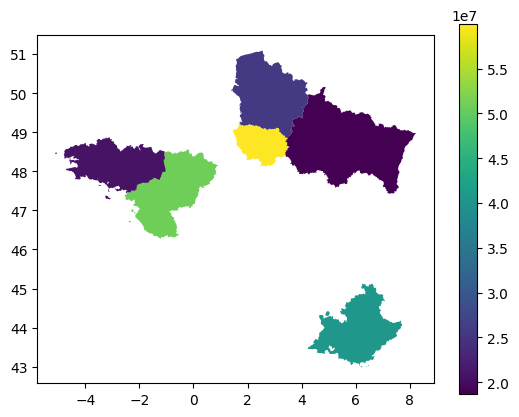

In [13]:
import matplotlib.pyplot as plt

region_mapping = {
    'Île-de-France': 'ILE-DE-FRANCE',
    'Centre-Val de Loire': 'CENTRE-VAL DE LOIRE',
    'Bourgogne-Franche-Comté': 'BOURGOGNE-FRANCHE-COMTE',
    'Normandie': 'NORMANDIE',
    'Hauts-de-France': 'HAUTS-DE-FRANCE',
    'Grand Est': 'GRAND EST',
    'Pays de la Loire': 'PAYS DE LA LOIRE',
    'Bretagne': 'BRETAGNE',
    'Nouvelle-Aquitaine': 'NOUVELLE-AQUITAINE',
    'Occitanie': 'OCCITANIE',
    'Auvergne-Rhône-Alpes': 'AUVERGNE-RHONE-ALPES',
    "Provence-Alpes-Côte d'Azur": 'PROVENCE-ALPES-COTE D\'AZUR',
    'Corse': 'CORSE',
}

# Appliquer le mappage à la colonne 'nom'
sf['region'] = sf['nom'].map(region_mapping)

# Maintenant, vous pouvez mapper les valeurs de co2
sf['value'] = sf['region'].map(co2region['co2_emissions_ton'])

# Créer une figure et des axes
fig, ax = plt.subplots(1, 1)

# Dessiner les données sur les axes
sf.plot(column='value', ax=ax, legend=True)

# Afficher la figure
plt.show()

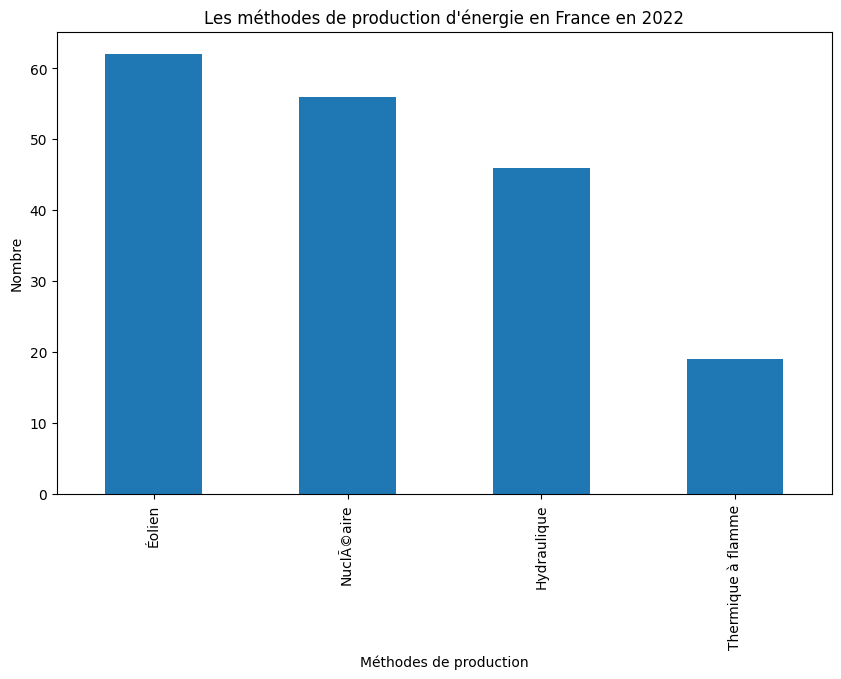

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
elements_counts=datacentrale['filiere'].value_counts()
plt.figure(figsize=(10, 6))
elements_counts.plot(kind='bar')
plt.title("Les méthodes de production d'énergie en France en 2022")
plt.xlabel('Méthodes de production')
plt.ylabel('Nombre')
plt.show()

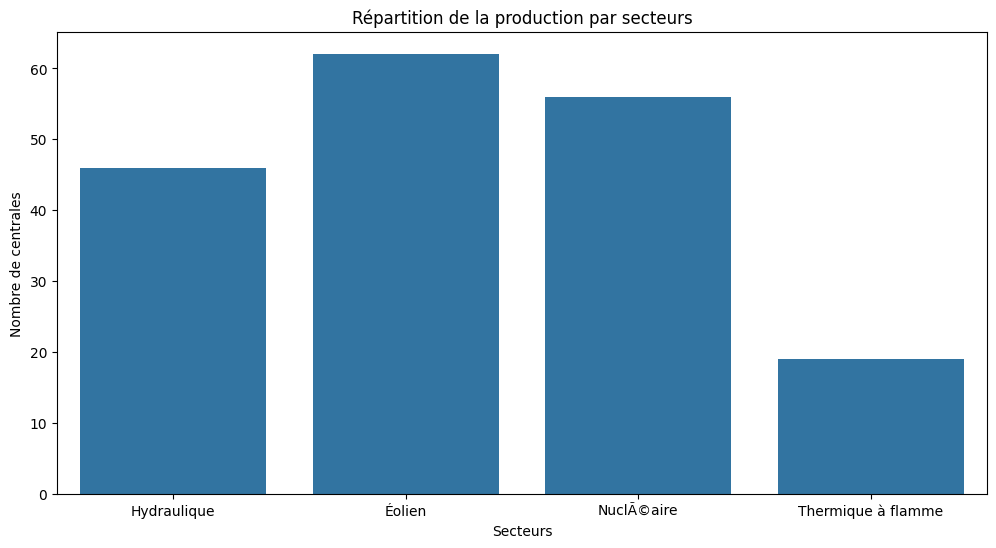

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(x='filiere', data=datacentrale)
plt.title('Répartition de la production par secteurs')
plt.xlabel('Secteurs')
plt.ylabel('Nombre de centrales')
plt.show()

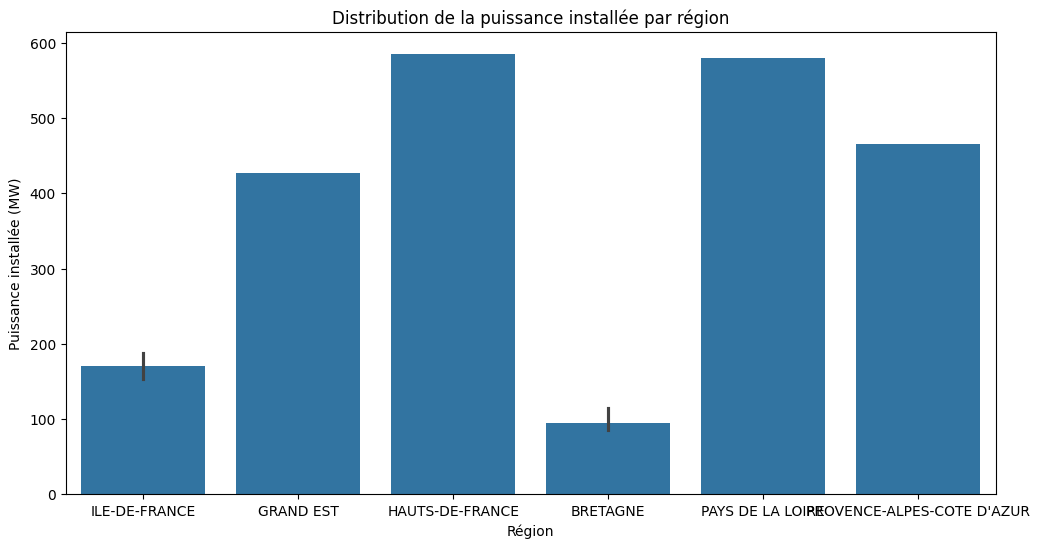

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(x='region', y='puissance_installee', data=datacentrale)
plt.title('Distribution de la puissance installée par région')
plt.xlabel('Région')
plt.ylabel('Puissance installée (MW)')
plt.show()

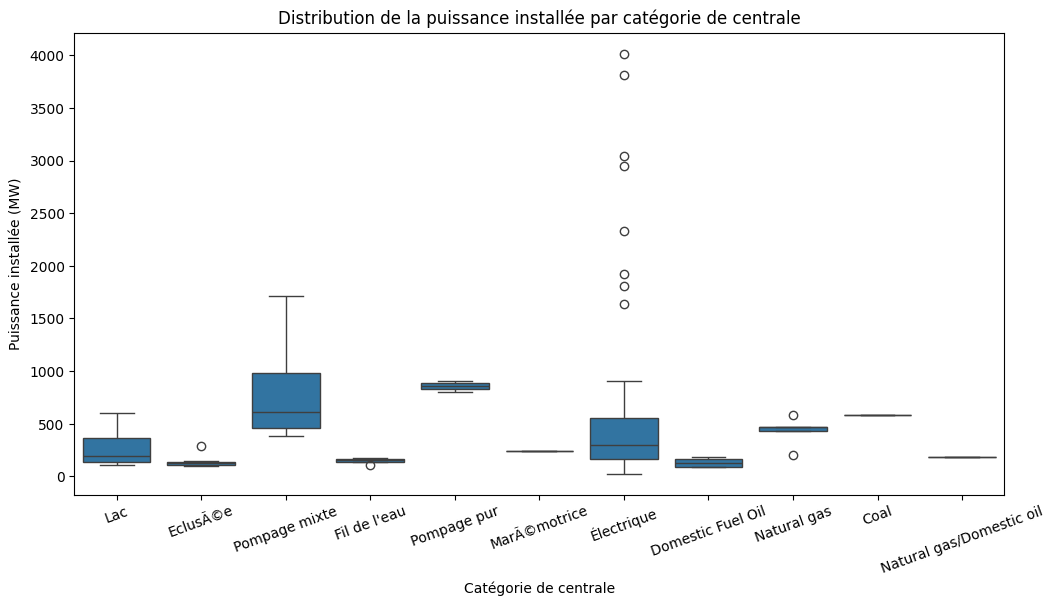

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='categorie_centrale', y='puissance_installee', data=datacentrale)
plt.title('Distribution de la puissance installée par catégorie de centrale')
plt.xlabel('Catégorie de centrale')
plt.ylabel('Puissance installée (MW)')
plt.xticks(rotation=20)
plt.show()


In [ ]:
import plotly.express as px

# Votre DataFrame (datacentrale) doit contenir la colonne 'filiere' et 'puissance_installee'
# Assurez-vous que les données sont propres (pas de valeurs manquantes)
datacentrale['puissance_installee_label'] = datacentrale['puissance_installee'].astype(str) + ' MW'

fig = px.treemap(datacentrale, path=['filiere'], values='puissance_installee',
                 title='Distribution of power capacity by sector (MW)',
                 custom_data=['puissance_installee_label'])

# Ajouter les valeurs de puissance_installee avec l'unité comme étiquettes
fig.update_traces(textinfo='label+value')

# Afficher le treemap
fig.show()